# 2 A: Time-series analysis and split-apply-combine processing

## Example: Use Xarray to find heatwaves in CMIP5 data

We'll define heatwaves as periods of 3 or more days that exceed the 90th percentile for that day of the year, with the percentiles calculated from a 15 day mean to smooth out the data.

As usual, we're focussing on techniques rather than science, so apologies if we get something wrong.

First let's load libraries and our sample data - daily max surface temperature from CMIP5

In [1]:
%matplotlib inline
import numpy
import xarray

In [2]:
cmip_tasmax  = '/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tasmax/tasmax*.nc'

ds = xarray.open_mfdataset(cmip_tasmax, chunks={'lat': 50, 'lon': 50})
tasmax = ds.tasmax

## Working in the time domain

Our analysis is time-based, so to start out with let's narrow down our data a little.

**Using the `.sel()` function, narrow down the dataset to a single lat/lon.**

<a href="#ans1" data-toggle="collapse">Answer</a>
<div class="collapse" id="ans1">
<pre><code>
# I'm using the coordinates for Melbourne here
tasmax_mel = tasmax.sel(lat=-37.8136, lon=144.9631, method='nearest')

# Since we've narrowed down the selection we can load the whole timeseries into memory
tasmax_mel.load()
</code></pre>
</div>

**Use `.plot()` to plot the time-series. You can use `.sel()` on the time axis to narrow down to a single year**

<a href="#ans2" data-toggle="collapse">Answer</a>
<div class="collapse" id="ans2">
<pre><code>
tasmax_mel.sel(time='1998').plot()
</code></pre>
</div>

In [3]:
# I'm using the coordinates for Melbourne here
tasmax_mel = tasmax.sel(lat=-37.8136, lon=144.9631, method='nearest')

# Since we've narrowed down the selection we can load the whole timeseries into memory
tasmax_mel.load()

<xarray.DataArray 'tasmax' (time: 56978)>
array([297.42963, 298.7173 , 301.43097, ..., 296.36945, 306.29263, 306.1634 ],
      dtype=float32)
Coordinates:
    lat      float64 -37.5
    lon      float64 144.4
    height   float64 1.5
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 1850-01-02T12:00:00 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    units:             K
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

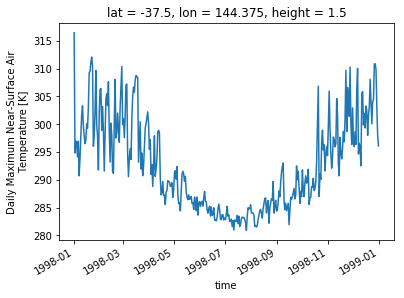

In [5]:
tasmax_mel.sel(time='1998').plot()

## Split-apply-combine

A common operation in both Xarray and Pandas is the 'split-apply-combine' operation

 1. **Split** the data into groups
 2. **Apply** a function to each group
 3. **Combine** the groups back into a dataset
 
We can split datasets in a few different ways with these 'split' functions:

 1. `.groupby()` to group by a coordinate (or component of a time coordinate)
 2. `.rolling()` to group using a rolling window on one of the coordinates
 3. `.resample()` to change the time frequency of data
 
We can then run a number of 'apply' functions on the grouped data:

 1. Basic stats - `.min()`, `.mean()`, `.std()`, `.count()`, etc.
 2. `.apply()` will run an arbitrary function on each group
 3. `.reduce()` will run an arbitrary function on each group that removes a dimension
 
Combining a 'split' and an 'apply' function will automatically combine the data into a new dataset (potentially with different dimensions)

**Use the 'split-apply-combine' pattern to calculate a 15-day rolling mean on the timeseries**

<a href="#ans3" data-toggle="collapse">Answer</a>
<div class="collapse" id="ans3">
<pre><code>
tasmax_mel_15day = tasmax_mel.rolling(time=15, center=True).mean()

# Plot the rolling mean
tasmax_mel_15day.sel(time='1998').plot()
</code></pre>
</div>

**Use the pattern again to calculate the 90th percentile for each day in the year from the 15 day mean**

<a href="#ans4" data-toggle="collapse">Answer</a>
<div class="collapse" id="ans4">
<pre><code>
threshold = tasmax_mel_15day.groupby('time.dayofyear').reduce(numpy.nanpercentile, q=90, dim='time')

# Compare the mean against the 90th percentile
tasmax_mel_15day.groupby('time.dayofyear').mean('time').plot()
threshold.plot()
</code></pre>
</div>

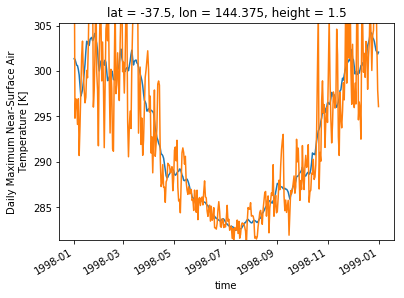

In [11]:
tasmax_mel.rolling(time=15, center=True).mean().sel(time='1998').plot()
tasmax_mel.sel(time='1998').plot()

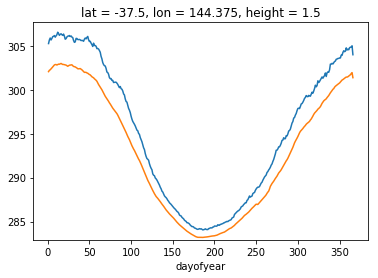

In [17]:
tasmax_mel_15d = tasmax_mel.rolling(time=15, center=True).mean()


p90_mel = tasmax_mel_15d.groupby('time.dayofyear').reduce(numpy.nanpercentile, q=90, dim='time')

p90_mel.plot()
tasmax_mel_15d.groupby('time.dayofyear').mean('time').plot()

## Filtering with `.where()`

You can mask out values in a DataArray using the `.where()` function. You give this a boolean field with the same dimensions as the DataArray, and it will return a new DataArray with `False` values masked out.

For our filter, we want values where the tasmax timeseries exceeds the 90th percentile, however these have different dimensions. The timeseries uses dates and the percentile is using the day of the year.

To harmonise the units we can use `.groupby()` again - if we group the timeseries by `time.dayofyear` we can subtract the percentile. Xarray will automatically pair up the matching groups.

**Filter out values from the timeseries below the 90th percentile**

<a href="#ans5" data-toggle="collapse">Answer</a>
<div class="collapse" id="ans5">
<pre><code>
candidates = tasmax_mel.where(tasmax_mel.groupby('time.dayofyear') > threshold)

# Plot the candidate points
tasmax_mel.sel(time='1998').plot()
candidates.sel(time='1998').plot(marker='.')
</code></pre>
</div>

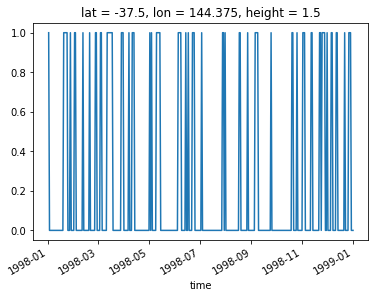

In [21]:
(tasmax_mel.groupby('time.dayofyear') > p90_mel).sel(time='1998').plot()

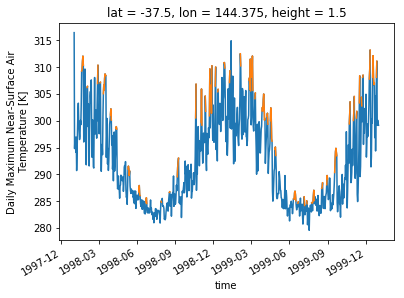

In [27]:
tasmax_mel.sel(time=slice('1998','1999')).plot()
tasmax_mel.where(tasmax_mel.groupby('time.dayofyear') > p90_mel).sel(time=slice('1998','1999')).plot()

candidates = tasmax_mel.where(tasmax_mel.groupby('time.dayofyear') > p90_mel)

## Spotting events

We now have a number of candidate points, days where the surface temperature exceeds the 90th percentile.

The final step is to spot events where there are at least three consecutive candidate points - these are the actual heatweaves. A simple way to do this is to use `.rolling(time=3)` with a 'apply' function. `.rolling()` will by default mask its output if any of the input points in its window are masked.

Now's the time to think about what you're going to do with the output of the analysis. Are you counting events? Then you don't want multiple matches if the heatwave lasts a long time. Are you using the result as a mask, to calculate something over the duration of the heatwave? Then you'll want to make sure you're matching the full duration.

This is where custom functions are useful - if you're making your own remember this is much easier on a single timeseries rather than a full 3d dataset.

**Use the 'heatwave_start_filter' function to identify the starts of heatwaves in the timeseries**

<a href="#ans6" data-toggle="collapse">Answer</a>
<div class="collapse" id="ans6">
<pre><code>
hw_starts = candidates.rolling(time=5, center=True, min_periods=1).reduce(heatwave_start_filter)

tasmax_mel.sel(time='1998').plot()
candidates.sel(time='1998').plot(marker='.')

# Scale the hw_start values so they show up against the temperatures
(hw_starts * 316).sel(time='1998').plot(marker='.')
</code></pre>
</div>

**Create a custom function that returns 1 for the full duration of a heatwave - if the heatwave lasts four days, it should return 1 for each of the four days and `nan` at other times**

<a href="#ans7" data-toggle="collapse">Answer</a>
<div class="collapse" id="ans7">
<pre><code>
def heatwave_active_filter(x, axis):
    """
    Returns 1 if a heatwave is active at this time, otherwise nan
    
    Matches any of the patterns [finite, finite, finite, *, *], [*, finite, finite, finite, *], 
    [*, *, finite, finite, finite] on the rolling dimension
    
    Should be called with x.rolling(time=5, center=True, min_periods=1).reduce(heatwave_active_filter)
    """

    # Check assumptions - the rolling axis is the last one, and the window size is 5
    assert axis % x.ndim == x.ndim - 1
    assert x.shape[axis] == 5

    left   = numpy.isfinite(x[..., 0:3]).all(axis=axis) # Times before this one
    center = numpy.isfinite(x[..., 1:4]).all(axis=axis) # Times around this one
    right  = numpy.isfinite(x[..., 2:]).all(axis=axis) # Times after this one
    
    test  = numpy.any([left, center, right], axis=0)
    return numpy.where(test, 1.0, numpy.nan)

hw_active = candidates.rolling(time=5, center=True, min_periods=1).reduce(heatwave_active_filter)

tasmax_mel.sel(time='1998').plot()
candidates.sel(time='1998').plot(marker='.')

(hw_starts \* 316).sel(time='1998').plot(marker='.')
(hw_active \* 313).sel(time='1998').plot(marker='.')
</code></pre>
</div>

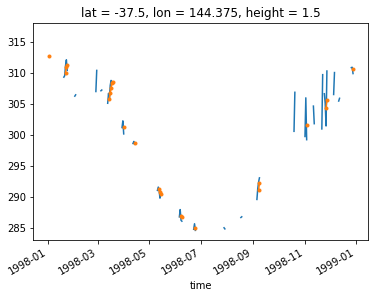

In [30]:
candidates.sel(time='1998').plot()
candidates.rolling(time=3).mean().sel(time='1998').plot(marker='.')


In [32]:
def heatwave_start_filter(x, axis):
    """
    Returns 1 if a heatwave starts at this time, otherwise nan
    
    Matches the pattern [*, nan, finite, finite, finite] on the rolling dimension
    
    Should be called with x.rolling(time=5, center=True, min_periods=1).reduce(heatwave_start_filter)
    """

    # Check assumptions - the rolling axis is the last one, and the window size is 5
    assert axis % x.ndim == x.ndim - 1
    assert x.shape[axis] == 5

    left  = numpy.isnan(x[..., 1]) # Time before this one

    right = numpy.isfinite(x[..., 2:]).all(axis=axis) # This time and two after
    
    test  = numpy.logical_and(left, right)
    return numpy.where(test, 1.0, numpy.nan)

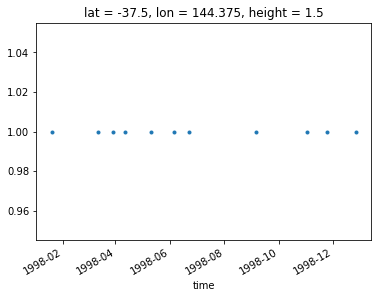

In [36]:
candidates.rolling(time=5, center=True, min_periods=1).reduce(heatwave_start_filter).sel(time='1998').plot(marker='.')

Text(0.5,1,'Number of heatwaves per year for Melbourne, ACCESS 1.3 CMIP5 Historical')

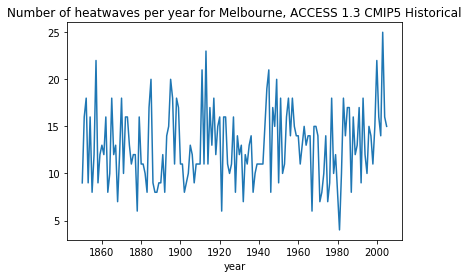

In [49]:
import matplotlib.pyplot as plt

# Get the 15-day mean
tasmax_mel_15d = tasmax_mel.rolling(time=15, center=True).mean()
# 90th percentile of the 15-day mean
p90_mel = tasmax_mel_15d.groupby('time.dayofyear').reduce(numpy.nanpercentile, q=90, dim='time')
# Days with tmax > that day's 90th percentile
candidates = tasmax_mel.where(tasmax_mel.groupby('time.dayofyear') > p90_mel)
# Filtered to only show the start of heatwaves
hw_starts = candidates.rolling(time=5, center=True, min_periods=1).reduce(heatwave_start_filter)
# Count the heatwaves per year
hw_starts.groupby('time.year').count().plot()

plt.title("Number of heatwaves per year for Melbourne, ACCESS 1.3 CMIP5 Historical")

In [44]:
def sample_func(x):
    print(x)
    return x.time/2

candidates.groupby('time.year').apply(sample_func)

<xarray.DataArray (time: 365)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    lat        float64 -37.5
    lon        float64 144.4
    height     float64 1.5
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 1850-01-02T12:00:00 ...
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    units:             K
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...


TypeError: ufunc true_divide cannot use operands with types dtype('<M8[ns]') and dtype('int64')